In [204]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
processed_path = '../data'
'''
cleaned_csv_files = [
  'TRAIN-1-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-2-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-3-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-4-DATA-IDS-2018-multiclass-bootstrap.csv',
  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.
]

list_of_dataframes = []
for filename in cleaned_csv_files:
    fname = os.path.join(processed_path, filename)
    list_of_dataframes.append(pd.read_csv(fname))

IDS_df = pd.concat(list_of_dataframes)
'''

"\ncleaned_csv_files = [\n  'TRAIN-1-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-2-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-3-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-4-DATA-IDS-2018-multiclass-bootstrap.csv',\n  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.\n]\n\nlist_of_dataframes = []\nfor filename in cleaned_csv_files:\n    fname = os.path.join(processed_path, filename)\n    list_of_dataframes.append(pd.read_csv(fname))\n\nIDS_df = pd.concat(list_of_dataframes)\n"

In [143]:
IDS_df = pd.read_csv("../data/CSE-CIC-IDS2018/IDS-2018-multiclass.csv")

# To display the top 5 rows/
# IDS_df.head(5)
IDS_df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [144]:
test_df = pd.read_csv(os.path.join(processed_path, 'TEST--DATA-IDS-2018-multiclass.csv'))

In [145]:
IDS_df = IDS_df.drop('timestamp', axis=1)

In [146]:
# for i in range(len(IDS_df.columns)):
#      print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

In [147]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(413648, 79)


In [148]:
print(test_df.shape)

(1613821, 79)


In [149]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

1900


In [150]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [151]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(412698, 79)


In [152]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


In [153]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(412698, 79)


In [154]:
# Finding the null values.
print(test_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

232


In [155]:
#  first replace infs to NaN:
test_df = test_df.replace([np.inf, -np.inf], np.nan)

In [156]:
# print shape after dropping NaN rows
test_df = test_df.dropna()
print(test_df.shape)
test_df = test_df.reset_index(drop=True)

(1613705, 79)


In [157]:
# Finding the null values.
print(test_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


In [158]:
print(test_df.shape)

(1613705, 79)


Examine the proportion of types of traffic:

In [159]:
IDS_df['label'].value_counts()

Benign                      199275
Infilteration                39777
SSH-Bruteforce               20000
DDoS attacks-LOIC-HTTP       20000
DoS attacks-Hulk             20000
DoS attacks-SlowHTTPTest     20000
Bot                          20000
DDOS attack-HOIC             20000
DoS attacks-GoldenEye        20000
FTP-BruteForce               19998
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: label, dtype: int64

In [160]:
test_df['label'].value_counts()

Benign                      1339012
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19335
SSH-Bruteforce                18759
Infilteration                 16064
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
DoS attacks-Slowloris          1099
DDOS attack-LOIC-UDP            173
Brute Force -Web                 61
Brute Force -XSS                 23
SQL Injection                     9
Name: label, dtype: int64

In [161]:
original_IDS_df = IDS_df
Y_train = IDS_df.pop("label")
X_train = IDS_df

In [172]:
original_IDS_df.shape

(412698, 78)

In [162]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE()

In [163]:
# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, Y_train)

In [164]:
#oversampled_trainY.value_counts()
# summarize distribution
from collections import Counter

counter = Counter(oversampled_trainY)
for k,v in counter.items():
    per = v / len(oversampled_trainY) * 100
    print('label=%s, n=%d (%.3f%%)' % (k, v, per))

label=DoS attacks-GoldenEye, n=199275 (6.667%)
label=DDoS attacks-LOIC-HTTP, n=199275 (6.667%)
label=Benign, n=199275 (6.667%)
label=DoS attacks-Hulk, n=199275 (6.667%)
label=DDOS attack-HOIC, n=199275 (6.667%)
label=Bot, n=199275 (6.667%)
label=FTP-BruteForce, n=199275 (6.667%)
label=SSH-Bruteforce, n=199275 (6.667%)
label=Infilteration, n=199275 (6.667%)
label=DoS attacks-SlowHTTPTest, n=199275 (6.667%)
label=DoS attacks-Slowloris, n=199275 (6.667%)
label=DDOS attack-LOIC-UDP, n=199275 (6.667%)
label=Brute Force -Web, n=199275 (6.667%)
label=Brute Force -XSS, n=199275 (6.667%)
label=SQL Injection, n=199275 (6.667%)


In [167]:
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)
oversampled_train.shape

(2989125, 79)

In [171]:
oversampled_train.columns

Index(['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_siz

In [173]:
#oversampled_train.columns = original_IDS_df.columns

In [174]:
print(original_IDS_df.columns)

Index(['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_siz

In [175]:
oversampled_train['label'].value_counts()

FTP-BruteForce              199275
DDOS attack-HOIC            199275
DDOS attack-LOIC-UDP        199275
SQL Injection               199275
Brute Force -Web            199275
Infilteration               199275
SSH-Bruteforce              199275
DoS attacks-Hulk            199275
DoS attacks-GoldenEye       199275
DoS attacks-Slowloris       199275
Bot                         199275
Benign                      199275
Brute Force -XSS            199275
DDoS attacks-LOIC-HTTP      199275
DoS attacks-SlowHTTPTest    199275
Name: label, dtype: int64

In [176]:
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 10
    elif text == 'DDOS attack-LOIC-UDP':
        return 11
    elif text == 'Brute Force -Web':
        return 12
    elif text == 'Brute Force -XSS':
        return 13
    elif text == 'SQL Injection':
        return 14

oversampled_train["label"] = oversampled_train["label"].apply(get_label)
test_df["label"] = test_df["label"].apply(get_label)

In [177]:
oversampled_train['label'].value_counts()

14    199275
13    199275
12    199275
11    199275
10    199275
9     199275
8     199275
7     199275
6     199275
5     199275
4     199275
3     199275
2     199275
1     199275
0     199275
Name: label, dtype: int64

Convert all categorical features into numerical form:

In [178]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        oversampled_train[c] = encodings_dictionary[c].fit_transform(oversampled_train[c])
        test_df[c] = encodings_dictionary[c].fit_transform(test_df[c])

Use Stratified K Fold to split the data into train and validation

In [179]:
seed = 1234
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed)
target = oversampled_train.loc[:,'label']

Train-test split the dataset:

In [180]:
def GetPyTorchDataLoaders(x_train, x_test, y_train, y_test, batch_size = 1000):
    # Pytorch
    X_train  = torch.from_numpy(x_train).float()
    Y_train = torch.from_numpy(y_train)

    X_test = torch.from_numpy(x_test).float()
    Y_test = torch.from_numpy(y_test)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(X_train, Y_train)
    valid = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

    print('Completed loading data and returning pytorch train and validation data loaders')
    return train_loader, valid_loader

In [207]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
# Defining the DNN model
#input_size = train_loader.dataset.tensors[0].shape[1]
input_size = 78
hidden_layers = [256,128,64]
output_size = 15

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.activ2 = nn.ReLU()

        self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        self.activ3 = nn.ReLU()
        
        self.layer4 = nn.Linear(hidden_layers[2], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        x = self.layer2(x)
        x = self.activ2(x)
        
        x = self.layer3(x)
        x = self.activ3(x)
        
        x = self.layer4(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# Adam Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

MLP(
  (layer1): Linear(in_features=78, out_features=256, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (activ2): ReLU()
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (activ3): ReLU()
  (layer4): Linear(in_features=64, out_features=15, bias=True)
)


In [208]:
def train_model(train, test, fold_no):
    print('Start training...')
    start_time = time.time()

    epochs = 1

    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    accuracy_scores = []
    
    # Separate into training data and labels, testing data and labels
    Y_train = train.pop("label").values
    X_train = train.values
    
    Y_test = test.pop("label").values
    X_test = test.values
    
    # Get PyTorch training and validation data loaders
    train_loader, valid_loader = GetPyTorchDataLoaders(X_train, X_test, Y_train, Y_test, batch_size = 5000)

    for e in range(epochs):
        correct_epoch = 0
        total_epoch = 0
        for i, (data, labels) in enumerate(train_loader):
            train = data.to(device)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0

                # Iterate through test dataset
                for data, labels in valid_loader:
                    valid = data.to(device)                               
                    labels = labels.to(device)

                    # Forward propagation
                    outputs = model(valid)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    #print('Predicted: ', predicted)

                    # Total number of labels
                    total += len(labels)
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                
            if count % 100 == 0:
                # Print Loss
                print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

            count += 1
        
        
        # calculate accuracy on the validation set
        # Iterate through test dataset
        for data, labels in valid_loader:
            valid = data.to(device)                               
            labels = labels.to(device)

            # Forward propagation
            outputs = model(valid)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            
            total_epoch += len(labels)
            correct_epoch += (predicted == labels).sum()

        accuracy_epoch = (100 * correct_epoch / float(total_epoch)).item()

        print('Fold',str(fold_no), 'Epoch No. :', e, 'Accuracy for Epoch :', accuracy_epoch)

    end_time = time.time()
    accuracy_scores.append(accuracy_epoch)
    mean_accuracy_score = np.mean(accuracy_scores)
    print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
    print('Average accuracy over all epochs', mean_accuracy_score)
    return mean_accuracy_score

In [ ]:
accuracy_scores = []
fold_no = 1

for train_index, test_index in skf.split(oversampled_train, target):
    train = oversampled_train.loc[train_index,:]
    test = oversampled_train.loc[test_index,:]
    accuracy_score = train_model(train, test, fold_no)
    accuracy_scores.append(accuracy_score)
    fold_no += 1
    
print('Accuracy score across after stratified K Fold validation and training', accuracy_score[-1])

Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 228779.90625  Accuracy: 11.446995735168457 %
Epoch: 1 Iteration: 100  Loss: 3748.9892578125  Accuracy: 55.1512565612793 %
Epoch: 1 Iteration: 200  Loss: 1449.14013671875  Accuracy: 47.837745666503906 %
Epoch: 1 Iteration: 300  Loss: 1609.274658203125  Accuracy: 56.710575103759766 %
Epoch: 1 Iteration: 400  Loss: 277.6749267578125  Accuracy: 55.06761932373047 %
Fold 1 Epoch No. : 0 Accuracy for Epoch : 57.504451751708984
Epochs completed. Time taken (seconds):  134.03818583488464
Average accuracy over all epochs 57.504451751708984
Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 552.2286987304688  Accuracy: 60.61372375488281 %


In [191]:
def GetPyTorchTestDataLoader(test_data, test_labels, batch_size=1000):
    # Pytorch

    X_test = torch.from_numpy(test_data).float()
    Y_test = torch.from_numpy(test_labels)

    # Pytorch train and test sets
    test = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    print('Completed loading data and returning pytorch test data loaders')
    return test_loader

In [192]:
test_labels = test_df.pop("label").values
test_data = test_df.values

KeyError: 'label'

In [193]:
test_loader = GetPyTorchTestDataLoader(test_data, test_labels, batch_size=5000)

Completed loading data and returning pytorch test data loaders


In [205]:
def plot_confusion_matrix(conf_matrix, label_names):
    '''Plot confusion matrix
    # param conf_matrix: confusion matrix nd array
    # return: None
    '''
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.7)
    # show all ticks
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    # label them with the respective list entries
    ax.set_xticklabels(label_names,  rotation=45)
    ax.set_yticklabels(label_names)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i,j], va='center', ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

Completed loading data and returning pytorch train and validation data loaders

In [195]:
# Aggregate all predictions in this torch tensor 
all_labels = torch.LongTensor([]).to(device)
all_predictions = torch.LongTensor([]).to(device)

for data, label in test_loader:
    valid = data.to(device)                               
    label = label.to(device)

    # Forward propagation
    outputs = model(valid)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    all_predictions = torch.cat(
        (all_predictions, predicted),
        dim =0
    )
    all_labels = torch.cat(
        (all_labels, label),
        dim =0
    )

In [196]:
print(all_labels.size())
print(all_predictions.size())

torch.Size([1613705])
torch.Size([1613705])


In [197]:
LABEL_TO_ID = {  
    "Benign": 0,
    'Infilteration': 1,
    'DoS attacks-Slowloris': 2,
    'SSH-Bruteforce': 3,
    'DDOS attack-HOIC': 4,
    'FTP-BruteForce': 5,
    'DoS attacks-SlowHTTPTest': 6,
    'Bot': 7,
    'DoS attacks-Hulk': 8,
    'DoS attacks-GoldenEye': 9,
    'DDoS attacks-LOIC-HTTP': 10,
    'DDOS attack-LOIC-UDP': 11,
    'Brute Force -Web': 12,
    'Brute Force -XSS': 13,
    'SQL Injection': 14,
}

ID_TO_LABEL = {
    v: k for k, v in LABEL_TO_ID.items()
}

In [198]:
label_names = []
for i in range(15):
    label_names.append(ID_TO_LABEL[i])

In [203]:
print(label_names)

['Benign', 'Infilteration', 'DoS attacks-Slowloris', 'SSH-Bruteforce', 'DDOS attack-HOIC', 'FTP-BruteForce', 'DoS attacks-SlowHTTPTest', 'Bot', 'DoS attacks-Hulk', 'DoS attacks-GoldenEye', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection']


Converting predictions torch tensor to numpy array
Plotting confusion matrix for test data


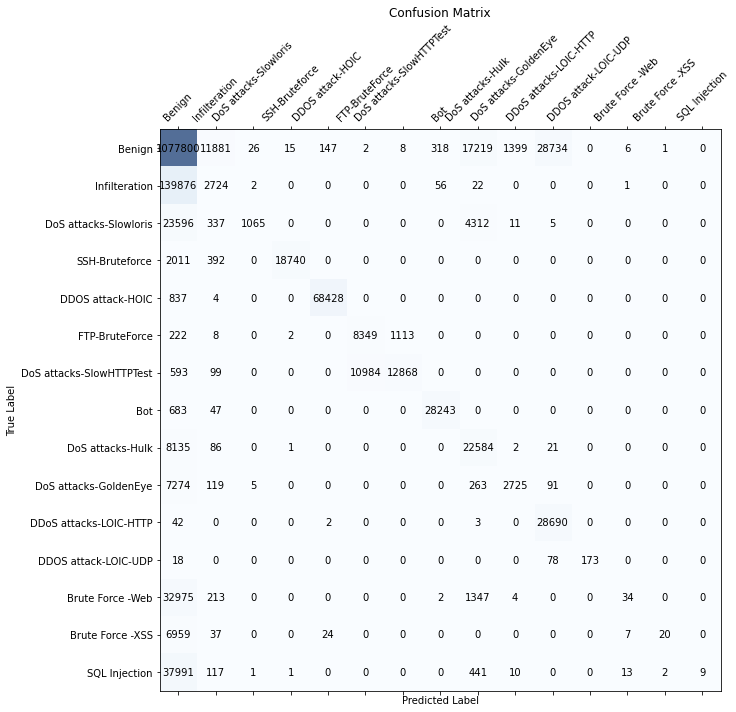

In [206]:
print('Converting predictions torch tensor to numpy array')
all_preds_np = all_predictions.cpu().data.numpy()
all_labels_np = all_labels.cpu().data.numpy()

# print the confusion matrix for this epoch and fold
print('Plotting confusion matrix for test data')
cnf_matrix = confusion_matrix(all_preds_np, all_labels_np, labels=[x for x in range(15)])
plot_confusion_matrix(cnf_matrix, label_names)    

In [ ]:
plt.plot(losses)
plt.xlabel("Number of folds")
plt.ylabel("Loss")
plt.title("Number of folds vs Loss")
plt.show()

# visualization accuracy 
plt.plot(accuracy_scores, color = "red")
plt.xlabel("Number of folds")
plt.ylabel("Accuracy")
plt.title("Number of folds vs Accuracy")
plt.show()